# Laboratorio 11 - Abandono de Clientes

----

Santiago Pereira 22318

Nancy Mazariegos 22513

----

### Librerías y carga de datos

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score, classification_report
)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [10, 6]

print("\nCARGA INICIAL")
print("-" * 50)


df = pd.read_csv('abandono_clientes.csv')
df_new = pd.read_csv('clientes_nuevos.csv').dropna(how='all').reset_index(drop=True)

print(f"Dataset entrenamiento: {df.shape}")
print(f"Dataset clientes nuevos: {df_new.shape}")


def normalize_cols(d):
    d = d.copy()
    d.columns = [c.strip().replace(" ", "_") for c in d.columns]
    if "Num_Sites" in d.columns:
        d = d.rename(columns={"Num_Sites": "Num_sites"})
    return d

df = normalize_cols(df)
df_new = normalize_cols(df_new)


print(f"\nINFORMACIÓN DEL DATASET")
print(f"Total de clientes: {len(df)}")
print(f"Características: {df.shape[1]-1}")
print(f"Variable objetivo: Churn")


display(df.head())


CARGA INICIAL
--------------------------------------------------
Dataset entrenamiento: (900, 10)
Dataset clientes nuevos: (6, 9)

INFORMACIÓN DEL DATASET
Total de clientes: 900
Características: 9
Variable objetivo: Churn


,Names,Age,Total_Purchase,Account_Manager,Years,Num_sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1



DISTRIBUCIÓN DE ABANDONO:
No abandonaron (0): 750 (83.3%)
Abandonaron (1): 150 (16.7%)


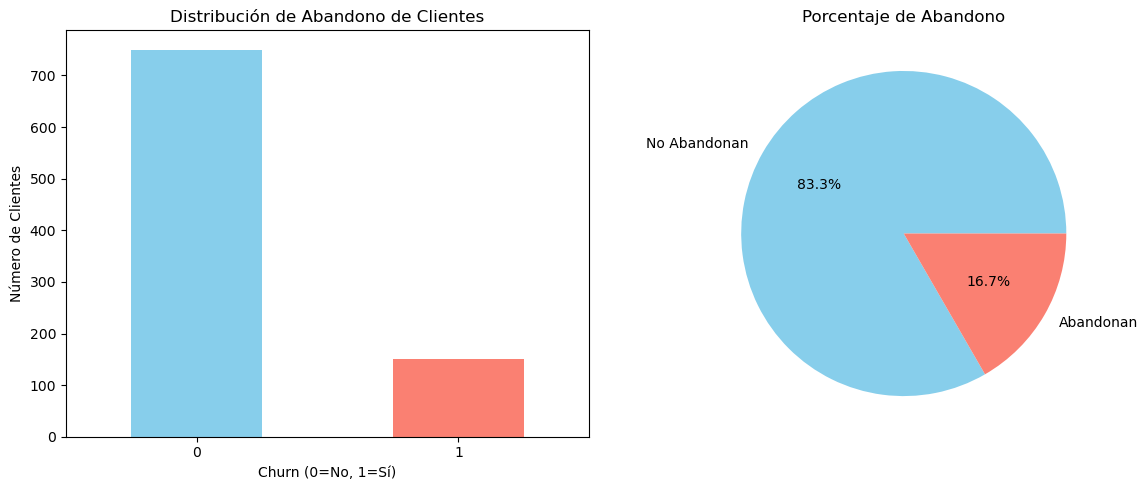

In [32]:

churn_dist = df['Churn'].value_counts()
print(f"\nDISTRIBUCIÓN DE ABANDONO:")
print(f"No abandonaron (0): {churn_dist[0]} ({churn_dist[0]/len(df)*100:.1f}%)")
print(f"Abandonaron (1): {churn_dist[1]} ({churn_dist[1]/len(df)*100:.1f}%)")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


churn_dist.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Distribución de Abandono de Clientes')
axes[0].set_xlabel('Churn (0=No, 1=Sí)')
axes[0].set_ylabel('Número de Clientes')
axes[0].tick_params(axis='x', rotation=0)


churn_pct = df['Churn'].value_counts(normalize=True) * 100
axes[1].pie(churn_pct.values, labels=['No Abandonan', 'Abandonan'], 
           autopct='%1.1f%%', colors=['skyblue', 'salmon'])
axes[1].set_title('Porcentaje de Abandono')

plt.tight_layout()
plt.show()

In [33]:

print(f"\nANÁLISIS EXPLORATORIO")
print("-" * 50)


numeric_cols = ['Age', 'Total_Purchase', 'Years', 'Num_sites']


print("Análisis comparativo por abandono:")
analysis_df = pd.DataFrame()
for col in numeric_cols:
    no_churn_stats = df[df['Churn'] == 0][col].agg(['mean', 'std'])
    churn_stats = df[df['Churn'] == 1][col].agg(['mean', 'std'])
    
    analysis_df[f'{col}_NoChurn_Mean'] = [no_churn_stats['mean']]
    analysis_df[f'{col}_Churn_Mean'] = [churn_stats['mean']]
    analysis_df[f'{col}_Difference'] = [churn_stats['mean'] - no_churn_stats['mean']]

print("\nDiferencias promedio entre grupos:")
for col in numeric_cols:
    no_churn = analysis_df[f'{col}_NoChurn_Mean'].iloc[0]
    churn = analysis_df[f'{col}_Churn_Mean'].iloc[0]
    diff = analysis_df[f'{col}_Difference'].iloc[0]
    print(f"{col:15}: No Churn={no_churn:8.2f}, Churn={churn:8.2f}, Diff={diff:+8.2f}")


ANÁLISIS EXPLORATORIO
--------------------------------------------------
Análisis comparativo por abandono:

Diferencias promedio entre grupos:
Age            : No Churn=   41.58, Churn=   42.99, Diff=   +1.41
Total_Purchase : No Churn=10036.95, Churn=10192.18, Diff= +155.23
Years          : No Churn=    5.15, Churn=    5.88, Diff=   +0.73
Num_sites      : No Churn=    8.17, Churn=   10.66, Diff=   +2.49



CORRELACIONES CON ABANDONO:
Num_sites      : +0.525
Years          : +0.214
Age            : +0.086
Account_Manager: +0.071
Total_Purchase : +0.024


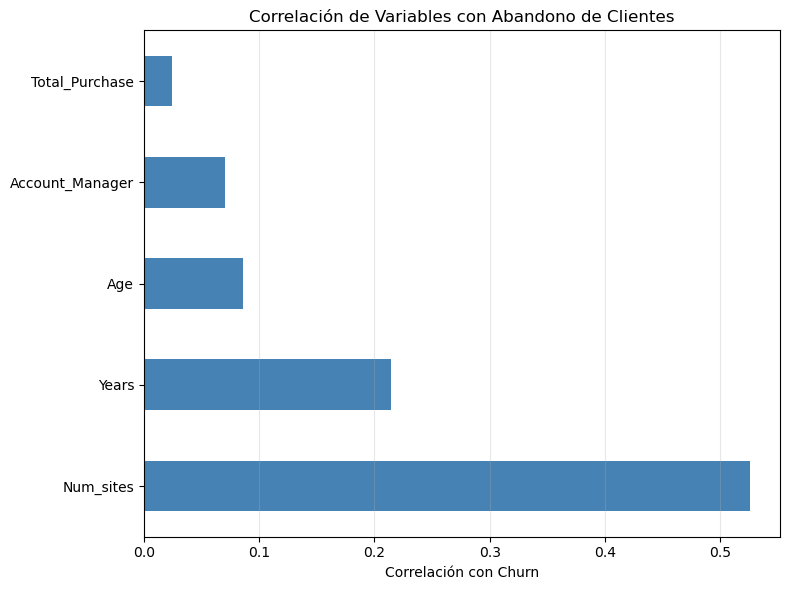


IMPACTO DEL GERENTE DE CUENTA:
Sin gerente (0): 14.1% abandona
Con gerente (1): 19.4% abandona


In [34]:

print(f"\nCORRELACIONES CON ABANDONO:")
feature_cols = numeric_cols + ['Account_Manager']
correlations = df[feature_cols + ['Churn']].corr()['Churn'].drop('Churn')
correlations = correlations.sort_values(ascending=False)

for feature, corr in correlations.items():
    print(f"{feature:15}: {corr:+6.3f}")


plt.figure(figsize=(8, 6))
correlations.plot(kind='barh', color='steelblue')
plt.title('Correlación de Variables con Abandono de Clientes')
plt.xlabel('Correlación con Churn')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


print(f"\nIMPACTO DEL GERENTE DE CUENTA:")
manager_analysis = pd.crosstab(df['Account_Manager'], df['Churn'], normalize='index') * 100
print(f"Sin gerente (0): {manager_analysis.loc[0, 1]:.1f}% abandona")
print(f"Con gerente (1): {manager_analysis.loc[1, 1]:.1f}% abandona")

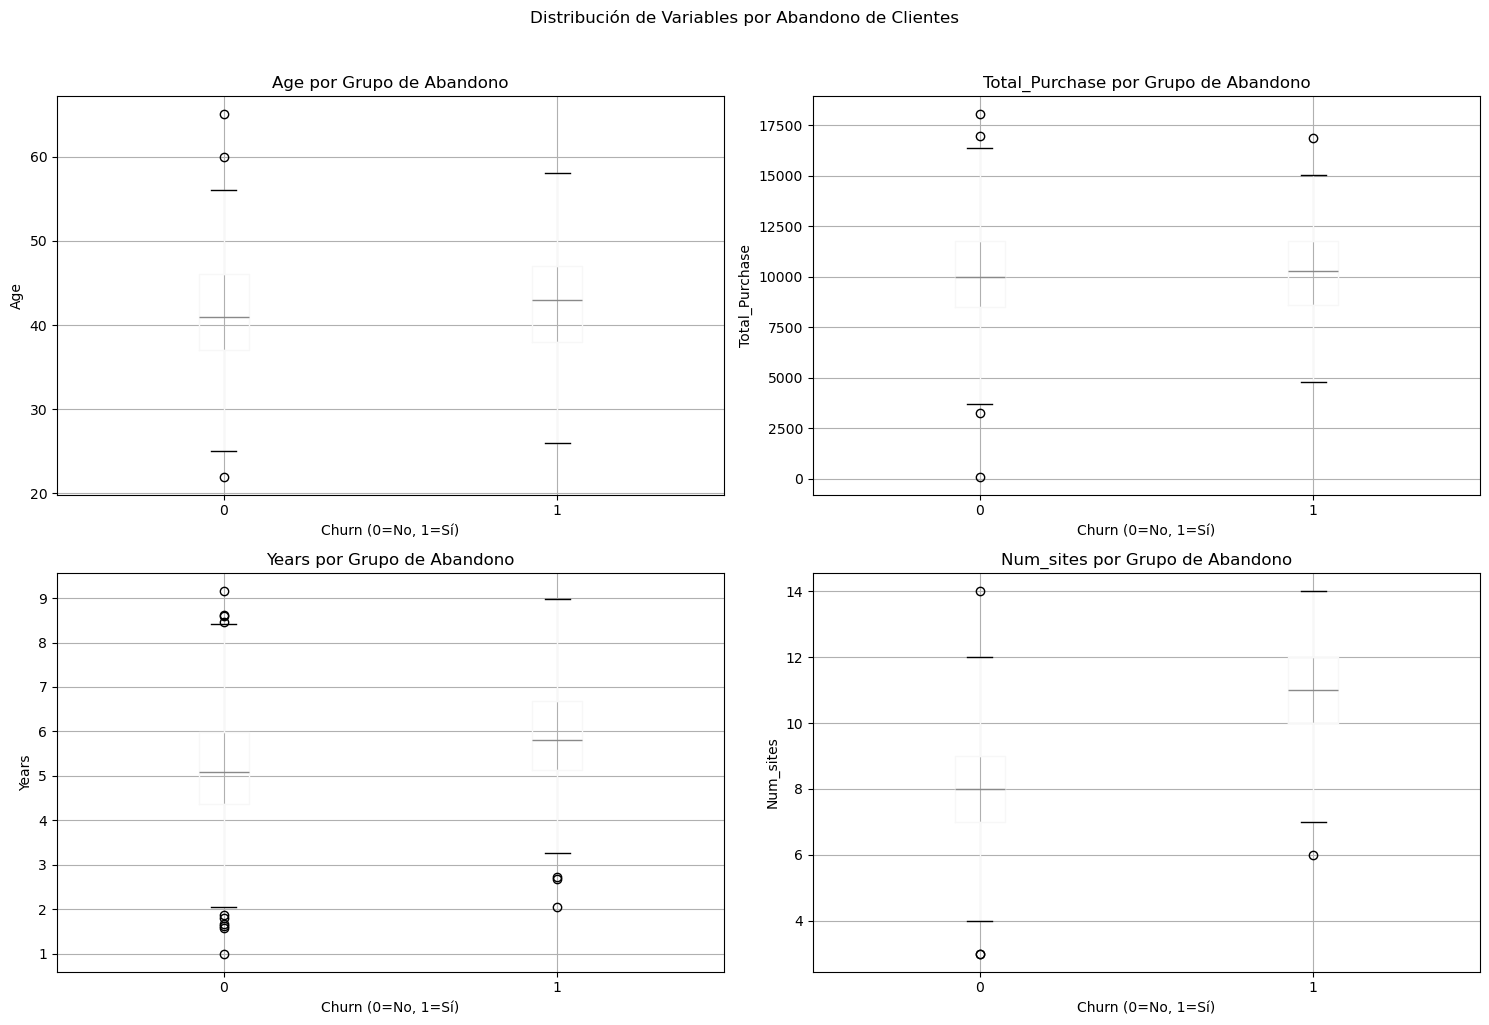

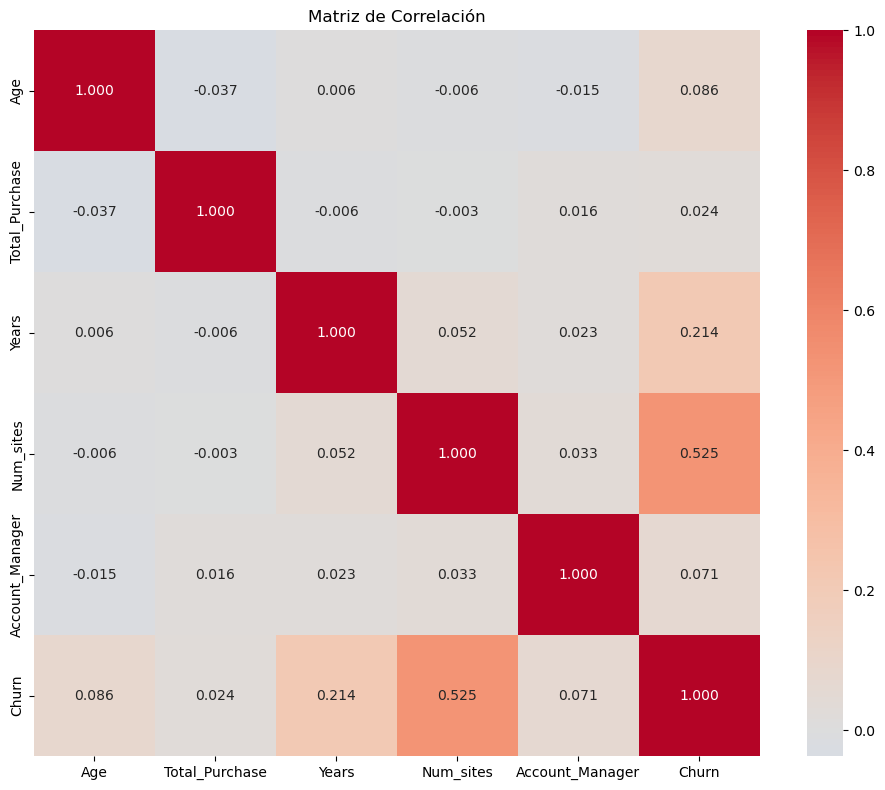

In [35]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    
    df.boxplot(column=col, by='Churn', ax=axes[i])
    axes[i].set_title(f'{col} por Grupo de Abandono')
    axes[i].set_xlabel('Churn (0=No, 1=Sí)')
    axes[i].set_ylabel(col)

plt.suptitle('Distribución de Variables por Abandono de Clientes', y=1.02)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 8))
corr_matrix = df[feature_cols + ['Churn']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

In [36]:

print(f"\nPREPARACIÓN DE DATOS")
print("-" * 50)


target_col = "Churn"
feature_names = ["Age", "Total_Purchase", "Account_Manager", "Years", "Num_sites"]

print(f"Características seleccionadas:")
for i, feat in enumerate(feature_names, 1):
    print(f"  {i}. {feat}")


X = df[feature_names].copy()
y = df[target_col].copy()


X["Account_Manager"] = X["Account_Manager"].astype(int)

print(f"\nInformación de características:")
print(X.info())
print(f"\nEstadísticas descriptivas:")
display(X.describe())


PREPARACIÓN DE DATOS
--------------------------------------------------
Características seleccionadas:
  1. Age
  2. Total_Purchase
  3. Account_Manager
  4. Years
  5. Num_sites

Información de características:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              900 non-null    float64
 1   Total_Purchase   900 non-null    float64
 2   Account_Manager  900 non-null    int64  
 3   Years            900 non-null    float64
 4   Num_sites        900 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 35.3 KB
None

Estadísticas descriptivas:


,Age,Total_Purchase,Account_Manager,Years,Num_sites
count,900.000000,900.000000,900.000000,900.000000,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778
std,6.127560,2408.644532,0.499921,1.274449,1.764836
min,22.000000,100.000000,0.000000,1.000000,3.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000



DIVISIÓN DE DATOS:
Entrenamiento: 630 muestras (70.0%)
Prueba: 270 muestras (30.0%)
Distribución entrenamiento: {0: 0.833, 1: 0.167}
Distribución prueba: {0: 0.833, 1: 0.167}


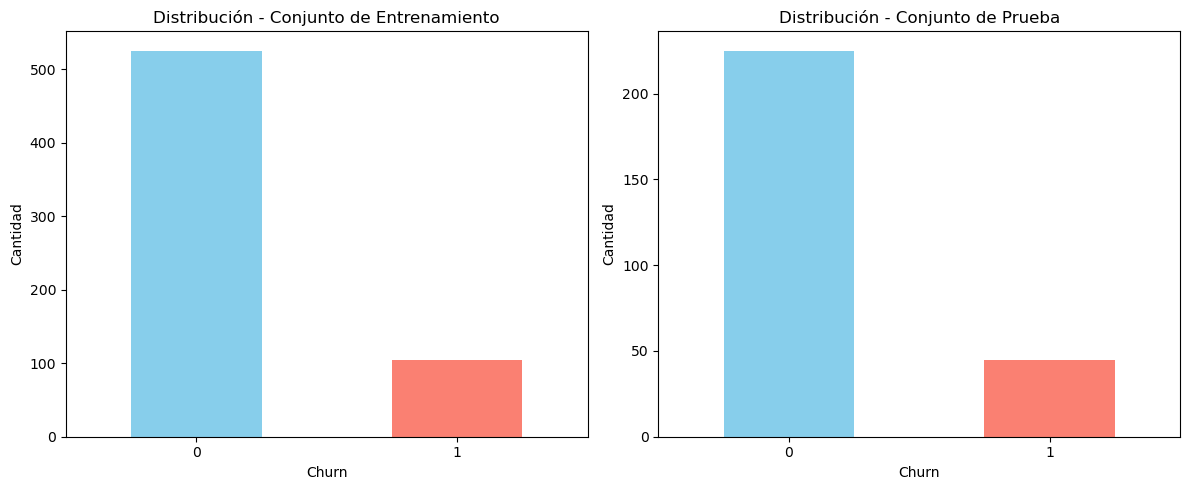

In [37]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print(f"\nDIVISIÓN DE DATOS:")
print(f"Entrenamiento: {X_train.shape[0]} muestras ({100*len(X_train)/len(X):.1f}%)")
print(f"Prueba: {X_test.shape[0]} muestras ({100*len(X_test)/len(X):.1f}%)")


train_dist = y_train.value_counts(normalize=True).round(3).to_dict()
test_dist = y_test.value_counts(normalize=True).round(3).to_dict()

print(f"Distribución entrenamiento: {train_dist}")
print(f"Distribución prueba: {test_dist}")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

y_train.value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Distribución - Conjunto de Entrenamiento')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Cantidad')
axes[0].tick_params(axis='x', rotation=0)

y_test.value_counts().plot(kind='bar', ax=axes[1], color=['skyblue', 'salmon'])
axes[1].set_title('Distribución - Conjunto de Prueba')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Cantidad')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [38]:

print(f"\nENTRENAMIENTO DEL MODELO")
print("-" * 50)


model_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])


model_pipeline.fit(X_train, y_train)
print("Modelo entrenado")


logistic_model = model_pipeline.named_steps['classifier']
feature_importance = pd.DataFrame({
    'Caracteristica': feature_names,
    'Coeficiente': logistic_model.coef_[0],
    'Importancia_Abs': np.abs(logistic_model.coef_[0])
}).sort_values('Importancia_Abs', ascending=False)

print(f"\nCOEFICIENTES DEL MODELO:")
display(feature_importance.round(4))
print(f"\nIntercepto: {logistic_model.intercept_[0]:.4f}")


ENTRENAMIENTO DEL MODELO
--------------------------------------------------
Modelo entrenado

COEFICIENTES DEL MODELO:


,Caracteristica,Coeficiente,Importancia_Abs
4,Num_sites,1.8962,1.8962
3,Years,0.7225,0.7225
0,Age,0.2807,0.2807
2,Account_Manager,0.2660,0.2660
1,Total_Purchase,0.0759,0.0759



Intercepto: -2.6641


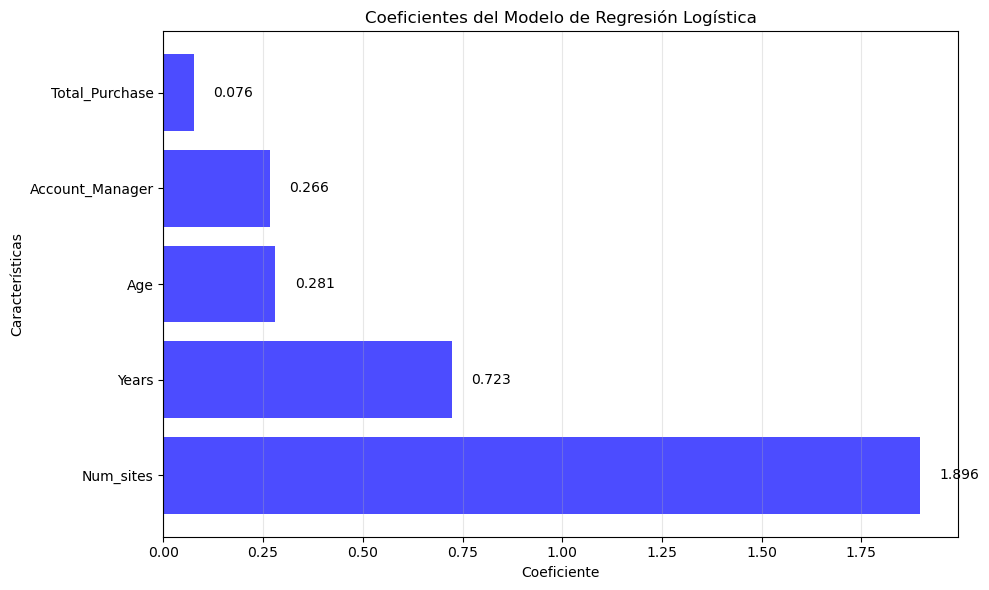


ECUACIÓN DEL MODELO:
P(Churn) = 1 / (1 + e^(-z))
donde z = -2.664 +0.281*Age +0.076*Total_Purchase +0.266*Account_Manager +0.723*Years +1.896*Num_sites


In [39]:

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'blue' for x in feature_importance['Coeficiente']]
bars = plt.barh(feature_importance['Caracteristica'], feature_importance['Coeficiente'], 
                color=colors, alpha=0.7)

plt.title('Coeficientes del Modelo de Regresión Logística')
plt.xlabel('Coeficiente')
plt.ylabel('Características')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', alpha=0.3)


for i, (bar, coef) in enumerate(zip(bars, feature_importance['Coeficiente'])):
    plt.text(coef + (0.05 if coef > 0 else -0.05), bar.get_y() + bar.get_height()/2, 
             f'{coef:.3f}', ha='left' if coef > 0 else 'right', va='center')

plt.tight_layout()
plt.show()


print(f"\nECUACIÓN DEL MODELO:")
print(f"P(Churn) = 1 / (1 + e^(-z))")
print(f"donde z = {logistic_model.intercept_[0]:.3f}", end="")
for feature, coef in zip(feature_names, logistic_model.coef_[0]):
    print(f" {coef:+.3f}*{feature}", end="")
print()

In [40]:

print("-" * 50)


y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)
y_train_proba = model_pipeline.predict_proba(X_train)[:, 1]
y_test_proba = model_pipeline.predict_proba(X_test)[:, 1]


def evaluate_model(y_true, y_pred, y_proba, dataset_name):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba)
    }
    return metrics

train_metrics = evaluate_model(y_train, y_train_pred, y_train_proba, "Entrenamiento")
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, "Prueba")


print("MÉTRICAS DE EVALUACIÓN:")
print(f"{'Métrica':<12} {'Entrenamiento':<15} {'Prueba':<15} {'Diferencia':<10}")
print("-" * 60)
for metric in train_metrics.keys():
    train_val = train_metrics[metric]
    test_val = test_metrics[metric]
    diff = abs(train_val - test_val)
    print(f"{metric:<12} {train_val:<15.4f} {test_val:<15.4f} {diff:<10.4f}")

--------------------------------------------------
MÉTRICAS DE EVALUACIÓN:
Métrica      Entrenamiento   Prueba          Diferencia
------------------------------------------------------------
Accuracy     0.8889          0.8926          0.0037    
Precision    0.7333          0.7857          0.0524    
Recall       0.5238          0.4889          0.0349    
F1-Score     0.6111          0.6027          0.0084    
ROC-AUC      0.8988          0.9276          0.0288    



MATRIZ DE CONFUSIÓN (Conjunto de Prueba):
                 Predicción
              No_Churn  Churn  Total
Real No_Churn     219       6     225
Real Churn         23      22      45
Total             242      28     270


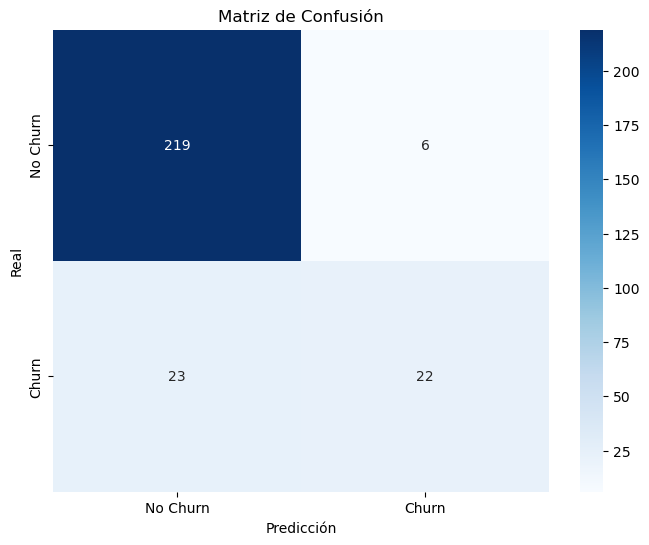


MÉTRICAS:
Verdaderos Negativos (TN): 219
Falsos Positivos (FP): 6
Falsos Negativos (FN): 23
Verdaderos Positivos (TP): 22
Especificidad: 0.9733
Sensibilidad: 0.4889
Precisión: 0.7857
Valor Predictivo Negativo: 0.9050


In [41]:

cm = confusion_matrix(y_test, y_test_pred)
print(f"\nMATRIZ DE CONFUSIÓN (Conjunto de Prueba):")
print(f"                 Predicción")
print(f"              No_Churn  Churn  Total")
print(f"Real No_Churn    {cm[0,0]:4d}    {cm[0,1]:4d}    {cm[0,0]+cm[0,1]:4d}")
print(f"Real Churn       {cm[1,0]:4d}    {cm[1,1]:4d}    {cm[1,0]+cm[1,1]:4d}")
print(f"Total            {cm[0,0]+cm[1,0]:4d}    {cm[0,1]+cm[1,1]:4d}    {cm.sum():4d}")


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
npv = tn / (tn + fn)

print(f"\nMÉTRICAS:")
print(f"Verdaderos Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdaderos Positivos (TP): {tp}")
print(f"Especificidad: {specificity:.4f}")
print(f"Sensibilidad: {sensitivity:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Valor Predictivo Negativo: {npv:.4f}")

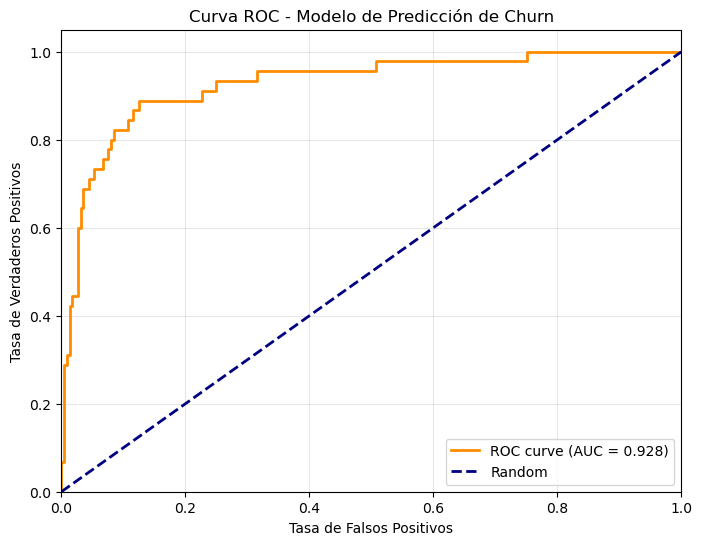


REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

    No Churn       0.90      0.97      0.94       225
       Churn       0.79      0.49      0.60        45

    accuracy                           0.89       270
   macro avg       0.85      0.73      0.77       270
weighted avg       0.89      0.89      0.88       270



In [42]:

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Modelo de Predicción de Churn')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


print(f"\nREPORTE DE CLASIFICACIÓN:")
report = classification_report(y_test, y_test_pred, target_names=['No Churn', 'Churn'])
print(report)

In [43]:

print(f"\nPREDICCIONES EN CLIENTES NUEVOS")
print("-" * 50)



print(f"\nDatos de clientes nuevos:")
display(df_new.head())


X_new_processed = pd.DataFrame()


for feature in feature_names:
    if feature in df_new.columns:
        X_new_processed[feature] = pd.to_numeric(df_new[feature], errors='coerce')
    else:
        print(f"Columna {feature} no encontrada en datos nuevos")
        X_new_processed[feature] = np.nan

print(f"\nDatos procesados para predicción:")
display(X_new_processed)


missing_values = X_new_processed.isnull().sum()
if missing_values.sum() > 0:
    print(f"\nVALORES FALTANTES:")
    for col, count in missing_values.items():
        if count > 0:
            print(f"  {col}: {count} valores")


PREDICCIONES EN CLIENTES NUEVOS
--------------------------------------------------

Datos de clientes nuevos:


,Names,Age,Total_Purchase,Account_Manager,Years,Num_sites,Onboard_date,Location,Company
0,37.0,9935.53,1,7.71,8.0,2011-08-29 18:37:54,"38612 Johnny Stravenue Nataliebury, WI 15717-8316",King Ltd,NaN
1,23.0,7526.94,1,9.28,15.0,2013-07-22 18:19:54,"21083 Nicole Junction Suite 332, Youngport, ME...",Cannon-Benson,NaN
2,65.0,100.00,1,1.00,15.0,2006-12-11 07:48:13,"085 Austin Views Lake Julialand, WY 63726-4298",Barron-Robertson,NaN
3,32.0,6487.50,0,9.40,14.0,2016-10-28 05:32:13,"922 Wright Branch North Cynthialand, NC 64721",Sexton-Golden,NaN
4,32.0,13147.71,1,10.00,8.0,2012-03-20 00:36:46,Unit 0789 Box 0734 DPO AP 39702,Wood LLC,NaN



Datos procesados para predicción:


,Age,Total_Purchase,Account_Manager,Years,Num_sites
0,9935.53,1,7.71,8.0,NaN
1,7526.94,1,9.28,15.0,NaN
2,100.00,1,1.00,15.0,NaN
3,6487.50,0,9.40,14.0,NaN
4,13147.71,1,10.00,8.0,NaN
5,8445.26,1,3.46,14.0,NaN



VALORES FALTANTES:
  Num_sites: 6 valores


In [44]:

predictions = model_pipeline.predict(X_new_processed)
probabilities = model_pipeline.predict_proba(X_new_processed)[:, 1]


client_names = df_new['Names'].values if 'Names' in df_new.columns else [f"Cliente_{i+1}" for i in range(len(df_new))]
companies = df_new['Company'].values if 'Company' in df_new.columns else ['N/A'] * len(df_new)

results_df = pd.DataFrame({
    'Cliente': client_names,
    'Empresa': companies,
    'Prediccion_Churn': predictions,
    'Probabilidad_Churn': probabilities,
    'Nivel_Riesgo': pd.cut(probabilities, 
                          bins=[0, 0.3, 0.7, 1.0], 
                          labels=['Bajo', 'Medio', 'Alto'])
})

print(f"\nRESULTADOS DE PREDICCIÓN:")
display(results_df)


output_file = 'predicciones_clientes_nuevos.csv'
results_df.to_csv(output_file, index=False)
print(f"\nResultados guardados en: {output_file}")


RESULTADOS DE PREDICCIÓN:


,Cliente,Empresa,Prediccion_Churn,Probabilidad_Churn,Nivel_Riesgo
0,37.0,NaN,1,1.000000,Alto
1,23.0,NaN,1,1.000000,Alto
2,65.0,NaN,1,0.992412,Alto
3,32.0,NaN,1,1.000000,Alto
4,32.0,NaN,1,1.000000,Alto
5,22.0,NaN,1,1.000000,Alto



Resultados guardados en: predicciones_clientes_nuevos.csv



RESUMEN DE PREDICCIONES:
Clientes que NO abandonarán: 0
Clientes que SÍ abandonarán: 6

 DISTRIBUCIÓN POR NIVEL DE RIESGO:
Riesgo Alto: 6 clientes (100.0%)
Riesgo Medio: 0 clientes (0.0%)
Riesgo Bajo: 0 clientes (0.0%)


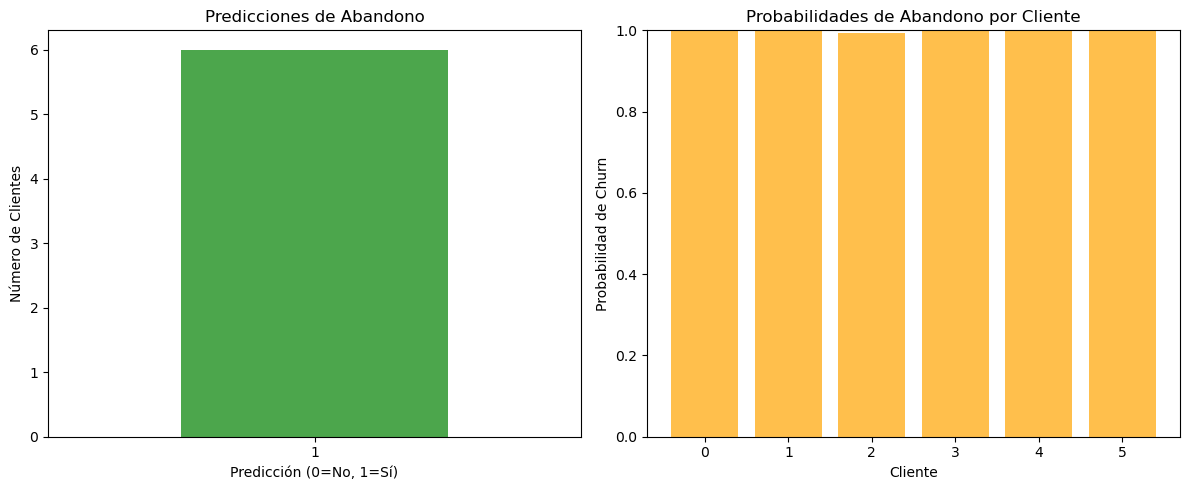


CLIENTES DE ALTO RIESGO (requieren gerente de cuenta):
  37.0 (nan) - Probabilidad: 1.000
  23.0 (nan) - Probabilidad: 1.000
  65.0 (nan) - Probabilidad: 0.992
  32.0 (nan) - Probabilidad: 1.000
  32.0 (nan) - Probabilidad: 1.000
  22.0 (nan) - Probabilidad: 1.000


In [45]:

pred_counts = results_df['Prediccion_Churn'].value_counts()
risk_counts = results_df['Nivel_Riesgo'].value_counts()

print(f"\nRESUMEN DE PREDICCIONES:")
print(f"Clientes que NO abandonarán: {pred_counts.get(0, 0)}")
print(f"Clientes que SÍ abandonarán: {pred_counts.get(1, 0)}")

print(f"\n DISTRIBUCIÓN POR NIVEL DE RIESGO:")
for level in ['Alto', 'Medio', 'Bajo']:
    count = risk_counts.get(level, 0)
    pct = count / len(results_df) * 100
    print(f"Riesgo {level}: {count} clientes ({pct:.1f}%)")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


pred_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Predicciones de Abandono')
axes[0].set_xlabel('Predicción (0=No, 1=Sí)')
axes[0].set_ylabel('Número de Clientes')
axes[0].tick_params(axis='x', rotation=0)


axes[1].bar(range(len(results_df)), probabilities, color='orange', alpha=0.7)
axes[1].set_title('Probabilidades de Abandono por Cliente')
axes[1].set_xlabel('Cliente')
axes[1].set_ylabel('Probabilidad de Churn')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


high_risk_clients = results_df[results_df['Prediccion_Churn'] == 1]
if len(high_risk_clients) > 0:
    print(f"\nCLIENTES DE ALTO RIESGO (requieren gerente de cuenta):")
    for _, row in high_risk_clients.iterrows():
        print(f"  {row['Cliente']} ({row['Empresa']}) - Probabilidad: {row['Probabilidad_Churn']:.3f}")